# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: December 12, 2022
- Instructor name: Morgan Jones
- Blog Post

# Summary


# Table of Contents

# Introduction
In the United States, pneumonia is the second most likely reason a person is admitted to a hospital, behind the birth of a child. Over 1 million adults will be admitted for pneumonia and complications each year.  

Pneumonia will keep an inflicted person's lungs from getting enough oxygen into their blood. Pneumonia is caused by inflamation around the air sacs of lungs. These air sacs may be filled with fluid or pus. Infections of fungi, viruses, or bacteria, or irritation from environmental factors may lead to pneumonia. According to the Center for Disease Control and Prevention (CDC) there are 14.4 deaths caused by pneumonia per 100,000 people in the population. That is about 50,000 death a year in the United States.

Early detection is critical in preventing death due to pneumonia. Symptoms of having pneumonia include chest pain, confusion, and fatigue. Pneumonia is diagnosed using a chest x-ray. A radiologist will interpret the x-ray and look for white spots, called infiltrates. Once diagnosed, treatment can begin to remove the excess fluid in the lungs.

## Business Problem

The Association of American Medical Colleges (AAMC) projects to have a serious shortage of radiologists by 2033. This is in contrast of the increase in medical imaging of about 5% a year. A shortage of radiologists will lead to worse patient outcomes as the turnaround time for them to make a diagnosis on the medical image increases.

Our company, United Healthcare, is an medical insurance company that provides health insurance through private and Affordable Care Act (ACA) health insurance exchanges. We are expanding our coverage to more rural clients and hospitals but this is where the shortage of specialty care such as radiology is the most serious.

With the increase cost and lower supply of radiologists, United Healthcare needs to develop an application to identify chest x-ray images that can classify if the patient has pneumonia or not. Those predicted to have pneumonia would be forwarded to a radiologist for a confirmed diagnosis. This will lessen the burden and cost of radiologists reviewing chest x-rays that are not indicative of pneumonia.

## Stakeholders
- United Healthcare executives
- Hospital workers

# Data
## Data Source
To find a solution to this business problem we need labeled chest x-ray images. There is a freely available dataset found on [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It was originally collected by [Kermany et al](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5). In the Kaggle location are 5,863 x-ray images in JPEG format. They are stored in directories labeled 'val', 'test', and 'train'. Within each of those directories the images are in folders 'PNEUMONIA' or 'NORMAL'.

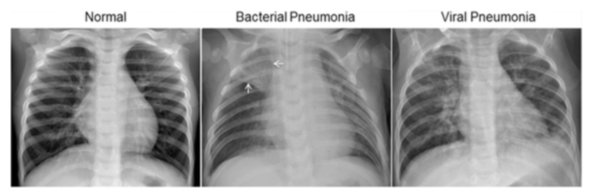

The data found in the NORMAL folders were compiled together as well as the images in the PNEUMONIA folders. These were then split into training and testing data using the python library [`python_splitter`](https://github.com/bharatadk/python_splitter). A compressed version of this cleaned data is available on [Amazon S3](https://flatiron-phase4-xray.s3.amazonaws.com/Train_Test_Folder.zip)


In [2]:
# Unpack the data.zip from Kaggle and turn into test-train split using python_splitter
# 80% will be in training, 20% in testing

import os
# absolute path of unzipped data directory
PATH = os.path.join(os.path.abspath(os.getcwd()),'data/')

# Uncomment the lines below to install python_splitter and create the
# trian test split
#!pip install python_splitter
#from python_splitter import split_from_folder # https://github.com/bharatadk/python_splitter
#split_from_folder(PATH, train = 0.8, test=0.2)

In [9]:
# Check for class imbalance between pneumonia and normal classified images
def file_count(path, class_name):
    '''
    This helper function takes a file directory and counts
    the number of files in each subdirectory.
    '''
    import os
    dir_path = os.path.join(path, class_name + '/')
    count = 0
    for root_dir, cur_dir, files in os.walk(dir_path):
        count += len(files)
    print(f'{class_name} file count: {count}')
    return count
    
normal_count = file_count(PATH, 'NORMAL')
pneumonia_count = file_count(PATH, 'PNEUMONIA')
total_count = normal_count + pneumonia_count

normal_weight = total_count / (2*normal_count)
pneumonia_weight = total_count / (2*pneumonia_count)

print(f'NORMAL weight: {normal_weight}')
print(f'PNEUMONIA weight: {pneumonia_weight}')

NORMAL file count: 1583
PNEUMONIA file count: 4273
NORMAL weight: 1.8496525584333543
PNEUMONIA weight: 0.6852328574771823


### Class Imbalance

The data consists of chest x-ray images of those that have pneumonia and those that do not (normal).
There is a total of 5,856 images of which 27% are in the normal class and 73% are in the pneumonia
class. This data is imbalanced and a model predicting could classify every image in this dataset as having pneumonia and it would be 73% accurate.

Class wieghts are inversely proportional to their respective frequencies. The formula to calculate the class weights is:

$$wj = n_samples/(n_classes * n_samples)$$

Keras has an attribute in its fit function where you can specify the class weights of the training data. This is telling the model to pay more attention to samples from the under-represented class, normal.

In [19]:
# Set directories for the train-test data
import os, shutil

data_path = os.path.join(os.path.abspath(os.getcwd()),'Train_Test_Folder/')
train_dir = os.path.join(data_path, 'train/')
test_dir = os.path.join(data_path, 'test/')
train_normal = os.path.join(train_dir, 'NORMAL/')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA/')

/home/kevinspring/Documents/Flatiron/phase04/Pneumonia-detection-using-CNN/Train_Test_Folder/


Image number: 1266
normal picture title:  NORMAL2-IM-1196-0001.jpeg
pneumonia picture title: person1590_virus_2764.jpeg


Text(0.5, 1.0, 'Pneumonia')

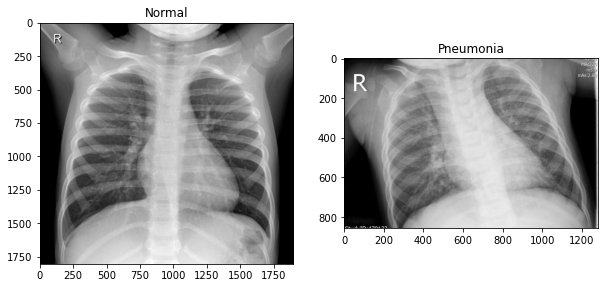

In [20]:
# Show a representative image of the data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f'Image number: {len(os.listdir(train_normal))}')
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load, cmap='gray')
ax2.set_title('Pneumonia')

# Modeling
Convolutional Neural Networks (CNN) is type of neural network that reduces the high dimensionality of images without losing its information. CNNs have outperformed other machine learning algorithms in image classification. The first layers in a CNN detect

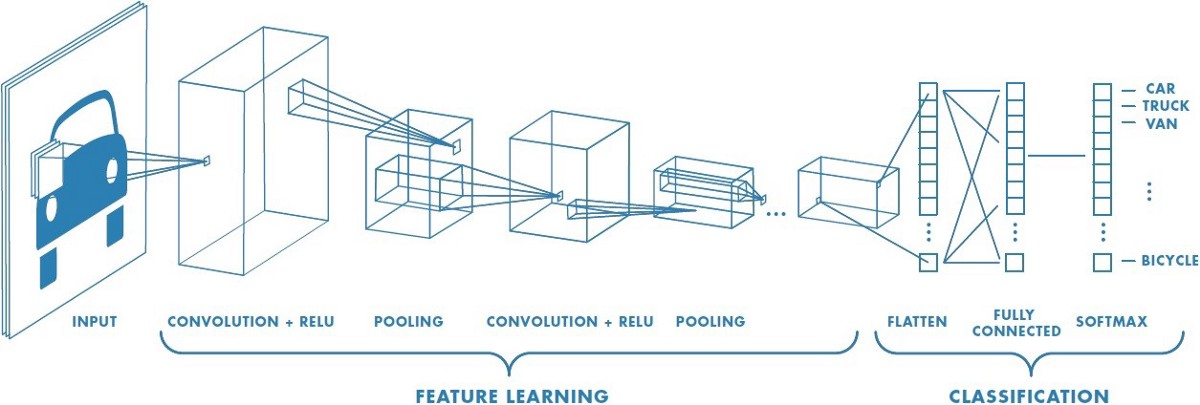

While densly connected neural networks learn global patterns in ther input feature space, convolution layers learn local paterns, that are found in 2-dimensional windows. This allows CNNs to learn patterns that are translation-invariant, something learned in one part of the image can be reused in another part. CNNs can also learn spatial heirarchies of patterns. The first layer of a CNN learns small local patterns such as edges. The next layer will learn larger patterns.

![CNN spatial hierarchies](img/spatial_hierarchy.PNG)

In [21]:
# Import data into tensorflow Dataset object
from tensorflow.keras.utils import image_dataset_from_directory

img_height = 128
img_width = 128
grayscale = 1
batch_size = 32

train_ds, val_ds = image_dataset_from_directory(train_dir,
                                        color_mode='grayscale',
                                        label_mode='binary',
                                        validation_split=0.2,
                                        subset='both',
                                        seed=42,
                                        #shuffle=False,
                                        image_size=(img_height, img_width),
                                        batch_size = batch_size)


test_ds = image_dataset_from_directory(test_dir,
                                       shuffle=False,
                                       color_mode='grayscale',
                                       label_mode='binary',
                                       image_size=(img_height, img_width)
                                      )

# print out the number of batches and data type
print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for training -->', train_ds.cardinality())

2022-12-06 10:43:36.214145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4684 files belonging to 2 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 2 classes.
Batches for testing --> tf.Tensor(37, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(30, shape=(), dtype=int64)
Batches for training --> tf.Tensor(118, shape=(), dtype=int64)


In [22]:
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['NORMAL', 'PNEUMONIA']
(32, 128, 128, 1)
(32, 1)


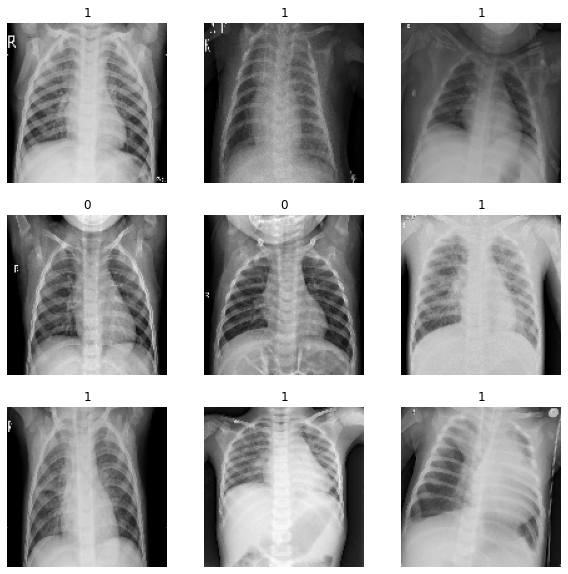

In [23]:
# Visualize the data stored in the tensorflow object
# 0 = normal
# 1 = pneumonia
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis('off')

In [24]:
# Configure the dataset for performance
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training the model.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
# libraries for neural networks
#from tensorflow import keras
from tensorflow.keras.models import Sequential
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.metrics import SpecificityAtSensitivity

In [26]:
def plot_fun(model, epochs):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'g-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'g-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model 1: Baseline model
This model implements a simple CNN. It rescales the the pixel data to be between 0 and 1. It then coes into one CNN layer, then downsizes the output through a max pooling layer. That is then flattened and put into a dense layer with one output. This output is a prediction of whether the image is classified as pneumonia (1) or normal (0).

In [29]:
#import tensorflow.keras import layers

batch_size = 32
learning_rate = 5e-4 #1e-3 #3e-4
epochs = 30

# Baseline model
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_baseline = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model_baseline.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model_baseline.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/baseline_model.keras',
        save_best_only=True,
        monitor='val_loss')
]

# Fit model
class_weights = {0: normal_weight,
                1: pneumonia_weight}
model_baseline_fit = model_baseline.fit(train_ds,
                                         epochs=epochs,
                                         validation_data = val_ds,
                                         batch_size=batch_size,
                                         callbacks=callbacks,
                                         class_weight=class_weights)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 127008)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 127009    
                                                           

Epoch 27/30
118/118 [==============================] - 9s 78ms/step - loss: 0.0375 - accuracy: 0.9904 - recall_2: 0.9894 - specificity_at_sensitivity_2: 1.0000 - val_loss: 0.1041 - val_accuracy: 0.9637 - val_recall_2: 0.9725 - val_specificity_at_sensitivity_2: 1.0000
Epoch 28/30
118/118 [==============================] - 9s 80ms/step - loss: 0.0355 - accuracy: 0.9925 - recall_2: 0.9916 - specificity_at_sensitivity_2: 1.0000 - val_loss: 0.1043 - val_accuracy: 0.9626 - val_recall_2: 0.9754 - val_specificity_at_sensitivity_2: 0.9959
Epoch 29/30
118/118 [==============================] - 10s 81ms/step - loss: 0.0310 - accuracy: 0.9941 - recall_2: 0.9930 - specificity_at_sensitivity_2: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9615 - val_recall_2: 0.9681 - val_specificity_at_sensitivity_2: 0.9959
Epoch 30/30
118/118 [==============================] - 9s 80ms/step - loss: 0.0280 - accuracy: 0.9939 - recall_2: 0.9934 - specificity_at_sensitivity_2: 1.0000 - val_loss: 0.1052 - val_accuracy: 

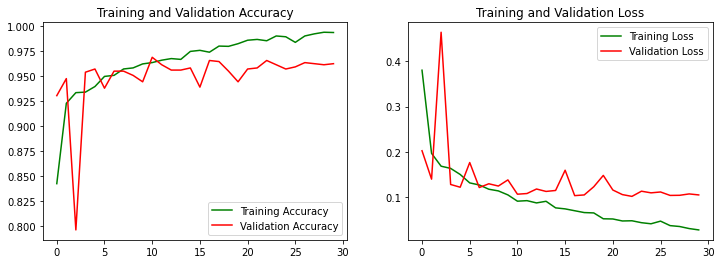

In [30]:
plot_fun(model_baseline_fit, epochs)

## Discussion of model 1

The training accuracy is increasing lineary while the training loss decreases. Around epoch 5 the validation accuracy and loss does not change.

In [56]:
# Model 2
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model2.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model2.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model2.keras',
        save_best_only=True,
        monitor='val_loss')
]

TypeError: SpecificityAtSensitivity.__init__() missing 1 required positional argument: 'sensitivity'

In [32]:
# Fit model
epochs=30
model2_fit = model2.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                        epochs=epochs,
                        validation_data = val_ds,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        class_weight=class_weights,
                        verbose=2)

Epoch 1/30
118/118 - 29s - loss: 0.4071 - accuracy: 0.7801 - recall_3: 0.7540 - specificity_at_sensitivity_3: 0.9716 - val_loss: 0.2833 - val_accuracy: 0.8878 - val_recall_3: 0.8522 - val_specificity_at_sensitivity_3: 0.9959 - 29s/epoch - 247ms/step
Epoch 2/30
118/118 - 32s - loss: 0.1836 - accuracy: 0.9280 - recall_3: 0.9282 - specificity_at_sensitivity_3: 0.9971 - val_loss: 0.1277 - val_accuracy: 0.9487 - val_recall_3: 0.9536 - val_specificity_at_sensitivity_3: 0.9959 - 32s/epoch - 267ms/step
Epoch 3/30
118/118 - 30s - loss: 0.1701 - accuracy: 0.9328 - recall_3: 0.9337 - specificity_at_sensitivity_3: 0.9971 - val_loss: 0.1136 - val_accuracy: 0.9647 - val_recall_3: 0.9667 - val_specificity_at_sensitivity_3: 0.9959 - 30s/epoch - 252ms/step
Epoch 4/30
118/118 - 33s - loss: 0.1438 - accuracy: 0.9450 - recall_3: 0.9461 - specificity_at_sensitivity_3: 0.9971 - val_loss: 0.1115 - val_accuracy: 0.9573 - val_recall_3: 0.9580 - val_specificity_at_sensitivity_3: 1.0000 - 33s/epoch - 280ms/step


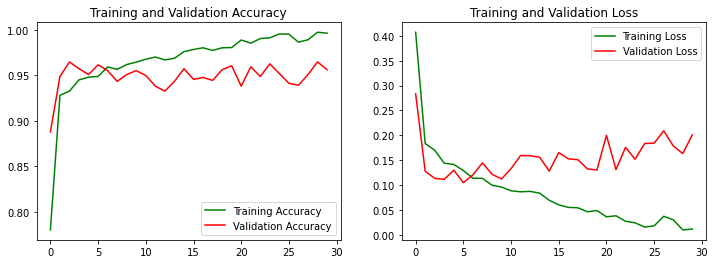

In [33]:
plot_fun(model2_fit, epochs)

## Discussion
Model 2 is able to overfit. This means that the model has the statistical power to generlize and not be underfitted. The next goal is to maximize generalization performance. I will use a dropout layer to regularize.

In [38]:
# Model 3
# Include a dropout
from keras.layers import Dropout

#learning_rate = 0.001
#batch_size=32

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model3.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model3.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model3.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                      

Epoch 1/40
118/118 [==============================] - 27s 227ms/step - loss: 0.0028 - accuracy: 0.9997 - recall_6: 1.0000 - specificity_at_sensitivity_6: 1.0000 - val_loss: 0.2940 - val_accuracy: 0.9466 - val_recall_6: 0.9464 - val_specificity_at_sensitivity_6: 0.9756
Epoch 2/40
118/118 [==============================] - 30s 254ms/step - loss: 0.0043 - accuracy: 0.9989 - recall_6: 0.9989 - specificity_at_sensitivity_6: 1.0000 - val_loss: 0.2700 - val_accuracy: 0.9444 - val_recall_6: 0.9754 - val_specificity_at_sensitivity_6: 0.9512
Epoch 3/40
118/118 [==============================] - 28s 239ms/step - loss: 0.0144 - accuracy: 0.9944 - recall_6: 0.9938 - specificity_at_sensitivity_6: 1.0000 - val_loss: 0.2787 - val_accuracy: 0.9423 - val_recall_6: 0.9493 - val_specificity_at_sensitivity_6: 0.9756
Epoch 4/40
118/118 [==============================] - 28s 237ms/step - loss: 0.0086 - accuracy: 0.9976 - recall_6: 0.9974 - specificity_at_sensitivity_6: 1.0000 - val_loss: 0.3115 - val_accurac

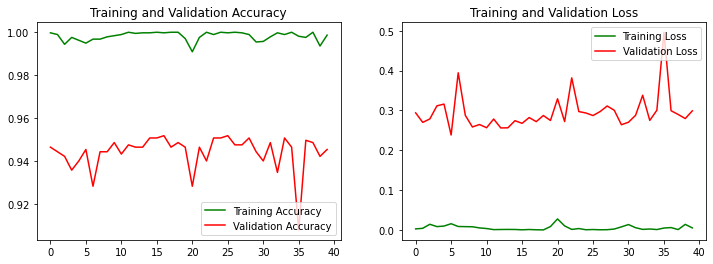

In [42]:
# Fit model
epochs=40
model3_fit = model3.fit(train_ds,
                        #steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights,
                         verbose=1)

plot_fun(model3_fit, epochs)

## Model 3 discussion
Including a dropout layer with class weights causes the validation accuracy to start at 100%

In [43]:
# Model 4: Data augmentationl

#learning_rate = 0.0005

from keras import layers

data_augmentation = Sequential(
        [
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ])

from keras.layers import Dropout

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model4.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.5)])

# Summary
model4.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model4.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 1)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        18496     
                                                           

Epoch 1/30


118/118 [==============================] - 43s 344ms/step - loss: 0.6268 - accuracy: 0.5998 - recall_8: 0.5425 - specificity_at_sensitivity_8: 0.7667 - val_loss: 0.6875 - val_accuracy: 0.6165 - val_recall_8: 0.4797 - val_specificity_at_sensitivity_8: 1.0000
Epoch 2/30
118/118 [==============================] - 41s 352ms/step - loss: 0.4190 - accuracy: 0.8050 - recall_8: 0.7977 - specificity_at_sensitivity_8: 0.9667 - val_loss: 0.5577 - val_accuracy: 0.7254 - val_recall_8: 0.6290 - val_specificity_at_sensitivity_8: 1.0000
Epoch 3/30
118/118 [==============================] - 41s 351ms/step - loss: 0.3339 - accuracy: 0.8482 - recall_8: 0.8398 - specificity_at_sensitivity_8: 0.9873 - val_loss: 0.2858 - val_accuracy: 0.8750 - val_recall_8: 0.8493 - val_specificity_at_sensitivity_8: 1.0000
Epoch 4/30
118/118 [==============================] - 40s 339ms/step - loss: 0.3092 - accuracy: 0.8679 - recall_8: 0.8662 - specificity_at_sensitivity_8: 0.9873 - val_loss: 0.2604 - val_accuracy: 0.8932 -

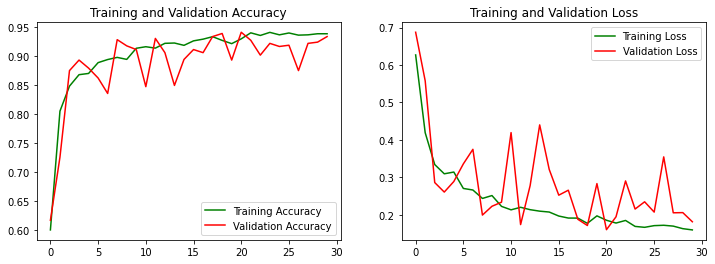

In [44]:
# Fit model
epochs=30
#batch_size = 8
model4_fit = model4.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)
plot_fun(model4_fit, epochs)

In [ ]:
# Discussion 5 epochs

In [47]:
# Model with transfer learning
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

conv_base.trainable = False

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [48]:
# Model 5
# With a pretrained model

#learning_rate = 0.00005

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs, outputs)

# Compile
model5.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate),
               metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m5_feature_extraction_with_data_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

Epoch 1/20


118/118 [==============================] - 470s 4s/step - loss: 5.7330 - accuracy: 0.8661 - val_loss: 3.4356 - val_accuracy: 0.9113
Epoch 2/20
118/118 [==============================] - 467s 4s/step - loss: 4.2503 - accuracy: 0.8975 - val_loss: 2.8136 - val_accuracy: 0.9306
Epoch 3/20
118/118 [==============================] - 470s 4s/step - loss: 3.0036 - accuracy: 0.9106 - val_loss: 3.1455 - val_accuracy: 0.9177
Epoch 4/20
118/118 [==============================] - 473s 4s/step - loss: 2.2092 - accuracy: 0.9240 - val_loss: 2.8423 - val_accuracy: 0.9156
Epoch 5/20
118/118 [==============================] - 157122s 4s/step - loss: 2.7678 - accuracy: 0.9128 - val_loss: 2.5037 - val_accuracy: 0.9209
Epoch 6/20
118/118 [==============================] - 466s 4s/step - loss: 1.9877 - accuracy: 0.9290 - val_loss: 2.3717 - val_accuracy: 0.9241
Epoch 7/20
118/118 [==============================] - 475s 4s/step - loss: 1.5798 - accuracy: 0.9312 - val_loss: 1.9948 - val_accuracy: 0.9177
Epoch 8

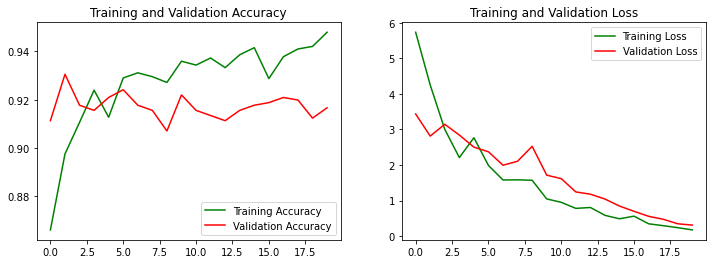

In [49]:
batch_size = 32
epochs = 20
model5_fit = model5.fit(train_ds,
                         #steps_per_epoch=10,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks)
plot_fun(model5_fit, epochs)

In [50]:
# Model 6: Unfreeze more layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
    
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m6_pretrained_cnn_top4unfrozen.keras',
        save_best_only=True,
        monitor='val_loss')
]

epochs = 30

model6_fit = model5.fit(train_ds,
                        epochs = epochs,
                        validation_data=val_ds,
                        callbacks=callbacks)

Epoch 1/30
118/118 [==============================] - 474s 4s/step - loss: 0.1430 - accuracy: 0.9520 - val_loss: 0.2941 - val_accuracy: 0.9220
Epoch 2/30
118/118 [==============================] - 480s 4s/step - loss: 0.1448 - accuracy: 0.9477 - val_loss: 0.2560 - val_accuracy: 0.9220
Epoch 3/30
118/118 [==============================] - 482s 4s/step - loss: 0.1275 - accuracy: 0.9560 - val_loss: 0.2531 - val_accuracy: 0.9241
Epoch 4/30
118/118 [==============================] - 481s 4s/step - loss: 0.1410 - accuracy: 0.9525 - val_loss: 0.2628 - val_accuracy: 0.9252
Epoch 5/30
118/118 [==============================] - 484s 4s/step - loss: 0.1344 - accuracy: 0.9501 - val_loss: 0.2214 - val_accuracy: 0.9263
Epoch 6/30
118/118 [==============================] - 483s 4s/step - loss: 0.1255 - accuracy: 0.9557 - val_loss: 0.2666 - val_accuracy: 0.9209
Epoch 7/30
118/118 [==============================] - 484s 4s/step - loss: 0.1258 - accuracy: 0.9538 - val_loss: 0.2344 - val_accuracy: 0.9209

KeyboardInterrupt: 

In [ ]:
plot_fun(model6_fit, epochs)

In [46]:
# Analyze models on test data

def model_evaluate(best_model, test_data):
    model = keras.models.load_model(best_model)
    test_loss, test_accuracy, test_recall, test_specificity = model.evaluate(test_data)
    print(f'Test accuracy of {best_model}: {test_accuracy:.3f}')

model_evaluate('models/keras/baseline_model.keras', test_ds)
model_evaluate('models/keras/model2.keras', test_ds)
model_evaluate('models/keras/model3.keras', test_ds)
model_evaluate('models/keras/model4.keras', test_ds)


37/37 [==============================] - 3s 73ms/step - loss: 0.1211 - accuracy: 0.9573 - recall_2: 0.9731 - specificity_at_sensitivity_2: 0.9937
Test accuracy of models/keras/baseline_model.keras: 0.957
37/37 [==============================] - 3s 88ms/step - loss: 0.1249 - accuracy: 0.9582 - recall_3: 0.9649 - specificity_at_sensitivity_3: 0.9937
Test accuracy of models/keras/model2.keras: 0.958
37/37 [==============================] - 3s 66ms/step - loss: 0.1265 - accuracy: 0.9531 - recall_6: 0.9708 - specificity_at_sensitivity_6: 0.9937
Test accuracy of models/keras/model3.keras: 0.953
37/37 [==============================] - 4s 97ms/step - loss: 0.1535 - accuracy: 0.9411 - recall_8: 0.9380 - specificity_at_sensitivity_8: 0.9968
Test accuracy of models/keras/model4.keras: 0.941


In [ ]:
def model_evaluate(best_model, test_data):
    model = keras.models.load_model(best_model)
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f'Test accuracy of {best_model}: {test_accuracy:.3f}')

model_evaluate('models/keras/m5_feature_extraction_with_data_augmentation.keras', test_ds)
model_evaluate('models/keras/m6_pretrained_cnn_top4unfrozen.keras', test_ds)

In [ ]:
# save and pickle model
model_best = model4
model_best_dir = 'models/best/model_xray_class.h5'
model_best.save(model_best_dir)

In [55]:
def predict_pneumonia(img_source, model):
    from tensorflow.keras.utils import load_img, img_to_array
    from tensorflow import keras
    
    # Load the model from the file
    model = keras.models.load_model(model)
    
    # Load the image
    img = load_img(img_source,
                   color_mode='grayscale',
                   target_size=(128,128))
    
    # Construct the tensor that .predict is expecting
    #img = load_img(img_source, target_size=(64, 64))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)/255
    
    # get the prediction and return
    prediction = model.predict(img, verbose=0)
    print(prediction)
    return prediction

img_src = 'app_img.jpeg'
model_src = 'models/keras/baseline_model.keras'

predict_pneumonia('app_img.jpeg', model_src)
predict_pneumonia('app_img_pneumonia.jpg', model_src)
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src)
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src)

[[0.95367646]]
[[0.953783]]
[[0.9541537]]
[[0.954162]]


array([[0.954162]], dtype=float32)

In [51]:
predict_pneumonia('apple.jpeg', model_src)

[[0.927866]]


array([[0.927866]], dtype=float32)